# 权重衰减的 Gluon 实现

本节将介绍如何使用 Gluon 实现上一节介绍的权重衰减。首先导入实验所需的包或模块。

In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

## 生成数据集

我们使用和上一节完全一样的方法生成数据集。

In [2]:
n_train = 20
n_test = 100
num_inputs = 200
true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

features = nd.random.normal(shape=(n_train+n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

num_epochs = 10
learning_rate = 0.003
batch_size = 1
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)
loss = gloss.L2Loss()

## 定义训练和测试

在训练和测试的定义中，我们分别定义了两个 Trainer 实例。其中一个对权重参数做 $L_2$ 范数正则化，另一个不对偏差参数做正则化。我们在上一节也提到了，实际中有时也对偏差参数做正则化。这样只需要定义一个 Trainer 实例就可以了。

In [3]:
def fit_and_plot(weight_decay):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数做 L2 范数正则化，即权重衰减。
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    # 不对偏差参数做 L2 范数正则化。
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {
        'learning_rate': learning_rate})
    train_ls = []
    test_ls = []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个 Trainer 实例分别调用 step 函数。
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    return 'w[:10]:', net[0].weight.data()[:,:10], 'b:', net[0].bias.data()

## 观察实验结果

以下实验结果和上一节中的类似：使用正则化可以在一定程度上缓解过拟合问题。

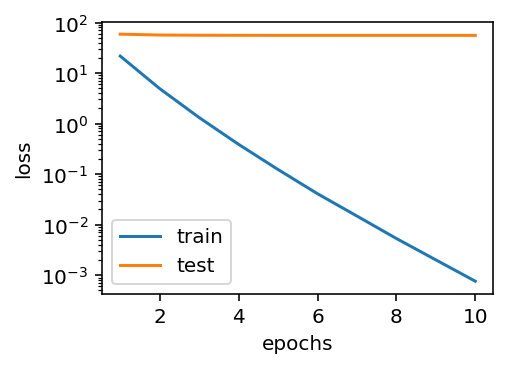

('w[:10]:', 
 [[-0.81733209 -0.22281203 -0.74906206 -2.25934839 -0.10182098 -0.69825244
   -0.09734779  0.6091494  -1.10476243 -1.44836748]]
 <NDArray 1x10 @cpu(0)>, 'b:', 
 [-0.38660702]
 <NDArray 1 @cpu(0)>)

In [4]:
fit_and_plot(0)

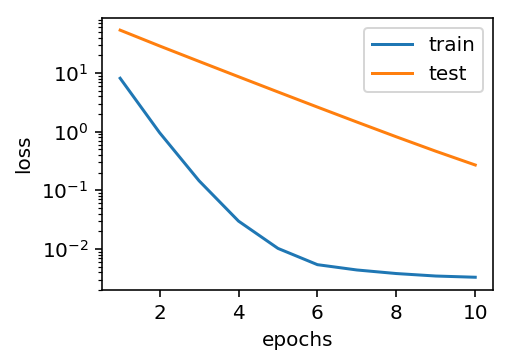

('w[:10]:', 
 [[ 0.01578885 -0.00399507 -0.02735567  0.00560922  0.00718523  0.01552427
    0.00853476  0.01398106  0.01990292 -0.00283106]]
 <NDArray 1x10 @cpu(0)>, 'b:', 
 [-0.14546333]
 <NDArray 1 @cpu(0)>)

In [5]:
fit_and_plot(5)

## 小结

* 使用 Gluon 的 `wd` 超参数可以使用权重衰减来应对过拟合问题。
* 我们可以定义多个 Trainer 实例对不同的模型参数使用不同的迭代方法。

## 练习

* 调一调本节实验中的 `wd` 超参数。观察并分析实验结果。

## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/985)

![](../img/qr_weight-decay-gluon.svg)